## Пример на pyspark

В качестве набора данных для примера будем использовать данные конкурса про ответы студентов на тесты
https://www.kaggle.com/c/riiid-test-answer-prediction

При подключении к spark драйверу установим лимиты по памяти и по числу ядер. Также выберем номер порта для Spark UI

Нужно выбрать уникальное имя приложения и номер порта, чтобы не войти в коллизию с другими пользователями

In [1]:
%pylab inline
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
        .builder
        .appName("OTUS-Solution")
        # .config("spark.dynamicAllocation.enabled", "true")
        # .config("spark.executor.memory", "2g")
        # .config("spark.driver.memory", "1g")
        .getOrCreate()
)

Данные будем читать из заранее сконвертированного parquet

In [4]:
riiid_df = spark.read.parquet("data/train.parquet",)

Схема данных и первые 10 записей

In [5]:
riiid_df.printSchema()

root
 |-- row_id: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- content_id: integer (nullable = true)
 |-- content_type_id: integer (nullable = true)
 |-- task_container_id: integer (nullable = true)
 |-- user_answer: integer (nullable = true)
 |-- answered_correctly: integer (nullable = true)
 |-- prior_question_elapsed_time: double (nullable = true)
 |-- prior_question_had_explanation: boolean (nullable = true)



In [6]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)  # to pretty print pyspark.DataFrame in jupyter
riiid_df.limit(10)

row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
62896,96541616,1400354,1087,0,94,3,0,17000.0,false
104413,21162902,2211492,5262,0,95,0,1,11000.0,true
537225,4538020,10854346,7880,0,26,1,1,30000.0,true
158202,95544,3237407,1278,0,3,0,0,23000.0,false
75576,45311590335,1567938,768,0,1665,0,1,17000.0,true
66732,17442041210,1440282,8340,0,3064,2,0,15000.0,true
256332,1868941165,4742725,8750,0,4144,0,0,14000.0,true
539919,3904128913,10938316,5986,0,596,0,1,12000.0,true
61801,8203657701,1308136,1289,0,20,3,1,19000.0,true
524048,2489081997,10353031,5262,0,195,0,1,24000.0,true


Замерим время выполнения простых запросов с группировками

In [11]:
from pyspark.sql import functions as f
from pyspark.sql.functions import col

In [ ]:
%%time
(
riiid_df
    .select('content_id', 'answered_correctly')
    .groupby('content_id')
    .mean('answered_correctly')
    .toPandas()
)



CPU times: user 64.7 ms, sys: 8.43 ms, total: 73.2 ms
Wall time: 3.91 s


,content_id,avg(answered_correctly)
0,7880,0.929134
1,1342,0.661290
2,7993,0.545455
3,6466,0.536585
4,5300,0.539474
...,...,...
13315,6153,0.625000
13316,3406,1.000000
13317,7466,1.000000
13318,12444,1.000000


In [8]:
%%time
(
riiid_df
    .select('user_id', 'answered_correctly')
    .groupby('user_id')
    .mean('answered_correctly')
    .toPandas()
)

CPU times: user 21.8 ms, sys: 131 µs, total: 22 ms
Wall time: 1.65 s


,user_id,avg(answered_correctly)
0,9656713,0.802817
1,3233182,0.627662
2,9970282,0.741430
3,6431206,0.617089
4,7039142,0.576923
...,...,...
3819,12092959,0.460000
3820,19997619,0.294118
3821,14531615,0.705882
3822,20443589,0.533333


## Упражнение 1
Выведите top 10 студентов с наилучшими результатами

In [9]:
%%time
(
riiid_df
    .select("user_id", "answered_correctly")
    .groupBy("user_id")
    .mean("answered_correctly")
    .orderBy("avg(answered_correctly)", ascending=False)
    .limit(10)
    .toPandas()
)

CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 1.52 s


,user_id,avg(answered_correctly)
0,1880240,1.000000
1,19087497,0.967742
2,7528236,0.967742
3,3126556,0.966667
4,7788970,0.966667
5,19190311,0.937500
6,10905154,0.933333
7,2212092,0.928571
8,1534292,0.923077
9,14998785,0.917647


## Упражнение 2
Выведите top 10 задач с наихудшими результатами

In [12]:
%%time
(
riiid_df
    .select("content_id", "answered_correctly")
    .filter(col("answered_correctly") >= 0)
    .groupBy("content_id")
    .mean("answered_correctly")
    .orderBy("avg(answered_correctly)", ascending=True)
    .limit(10)
    .toPandas()
)

CPU times: user 4.65 ms, sys: 8.09 ms, total: 12.7 ms
Wall time: 1.68 s


,content_id,avg(answered_correctly)
0,12401,0.0
1,12344,0.0
2,1884,0.0
3,12530,0.0
4,9338,0.0
5,13060,0.0
6,516,0.0
7,12799,0.0
8,3042,0.0
9,4401,0.0


## pyspark user defined functions (UDF)

Как и для других языков, поддерживаемых Spark, для python есть возможность использовать UDF. При этом возникают дополнительные накладные расходы по сравнению с Java и Scala на маршалинг данных.

In [13]:
from pyspark.sql.types import LongType

def to_months(ms):
    return ms // 31536000000 // 12 #1 year = 31536000000 ms

to_months_udf = f.udf(to_months, LongType())

Замерим время выполнения без UDF

In [14]:
%%time
(
    riiid_df
        .select("content_id", "timestamp")
        .groupby("content_id")
        .mean("timestamp")
        .toPandas()
)

CPU times: user 103 ms, sys: 4.56 ms, total: 107 ms
Wall time: 1.27 s


,content_id,avg(timestamp)
0,7880,6.035222e+09
1,1342,7.750259e+09
2,7993,9.291446e+09
3,6466,8.218247e+09
4,5300,5.720628e+09
...,...,...
13315,6153,1.583090e+09
13316,3406,2.398304e+08
13317,7466,1.453746e+10
13318,12444,1.369568e+09


Применим простой UDF к похожему запросу

In [15]:
%%time
(
    riiid_df
        .select("content_id", to_months_udf("timestamp").alias("months"))
        .groupBy("content_id")
        .mean("months")
        .toPandas()
)

CPU times: user 91.5 ms, sys: 16.6 ms, total: 108 ms
Wall time: 4.41 s


,content_id,avg(months)
0,7880,0.0
1,1342,0.0
2,7993,0.0
3,6466,0.0
4,5300,0.0
...,...,...
13315,6153,0.0
13316,3406,0.0
13317,7466,0.0
13318,12444,0.0


Перепишем логику, которая была в UDF

In [ ]:
%%time
(
    riiid_df
        .select("content_id", (col("timestamp") / 31536000000 / 12).alias("months"))
        .groupby("content_id")
        .mean("months")
        .toPandas()
)

CPU times: user 94.8 ms, sys: 170 µs, total: 94.9 ms
Wall time: 1.42 s


,content_id,avg(months)
0,7880,0.015948
1,1342,0.020480
2,7993,0.024552
3,6466,0.021717
4,5300,0.015117
...,...,...
13315,6153,0.004183
13316,3406,0.000634
13317,7466,0.038415
13318,12444,0.003619


## Упражнение 3
Постройте гистограмму по числу месяцев до первого взаимодействия студента с заданием

In [18]:
days_histogram = riiid_df.select(col('timestamp') / 31536000000 / 12).rdd.flatMap(lambda x: x).histogram(100)

In [20]:
days_histogram

([0.0,
  0.002063567471989684,
  0.004127134943979368,
  0.006190702415969052,
  0.008254269887958736,
  0.01031783735994842,
  0.012381404831938104,
  0.014444972303927788,
  0.016508539775917472,
  0.018572107247907158,
  0.02063567471989684,
  0.022699242191886522,
  0.024762809663876208,
  0.026826377135865893,
  0.028889944607855576,
  0.030953512079845258,
  0.033017079551834944,
  0.03508064702382463,
  0.037144214495814315,
  0.039207781967803994,
  0.04127134943979368,
  0.043334916911783365,
  0.045398484383773044,
  0.04746205185576273,
  0.049525619327752415,
  0.0515891867997421,
  0.05365275427173179,
  0.055716321743721466,
  0.05777988921571115,
  0.05984345668770084,
  0.061907024159690516,
  0.0639705916316802,
  0.06603415910366989,
  0.06809772657565957,
  0.07016129404764926,
  0.07222486151963894,
  0.07428842899162863,
  0.0763519964636183,
  0.07841556393560799,
  0.08047913140759767,
  0.08254269887958736,
  0.08460626635157704,
  0.08666983382356673,
  0.08873

In [19]:
import numpy as np

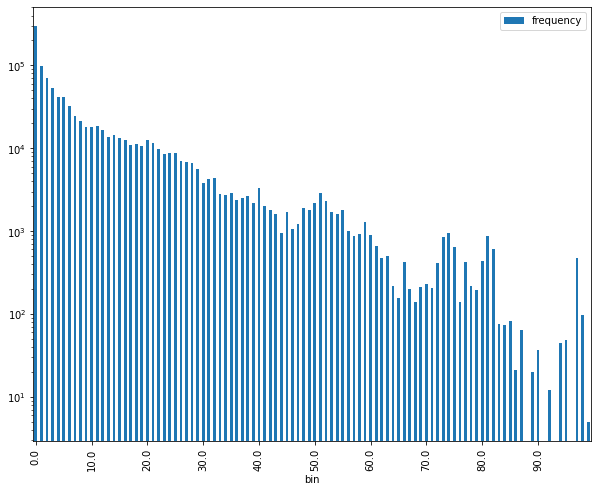

In [21]:
ax = pd.DataFrame(
    list(zip(*days_histogram)), columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar', figsize=(10,8))
ax.set_yscale('log')
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, tick_num: np.round(x, 2)))

## Упражнение 4
В файле "lectures.csv" хранится информация об лекциях. Объедините эту таблицу с основным набором данных при условии, что content_type_id == 1.

In [23]:
lectures = spark.read.csv("data/lectures.csv", header=True, inferSchema=True)

In [24]:
lec_df = (
    riiid_df
        .where(f.col("content_type_id") == 1)
        .join(lectures, riiid_df.content_id == lectures.lecture_id, 'left')
)

In [25]:
%%time
(
lec_df
    .groupBy("tag")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
    .toPandas()
)

CPU times: user 9.28 ms, sys: 0 ns, total: 9.28 ms
Wall time: 1.78 s


,tag,count
0,62,601
1,27,553
2,136,420
3,163,400
4,26,393
5,161,392
6,170,376
7,1,351
8,73,337
9,53,321
